## Fraud Detection Model
https://www.kaggle.com/competitions/ieee-fraud-detection/data

In [18]:
import numpy as np
import pandas as pd

from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
test_data = pd.read_csv('./Data/test_combined.csv')
test_data.head(5)

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
train_data = pd.read_csv('./Data/train_combined.csv')
train_data.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [7]:
exclude_columns = {"TransactionID", "isFraud", "TransactionDT", "TransactionAmt"}

with open("unique_values.txt", "w") as file:
    for col in train_data.columns:
        if col not in exclude_columns:
            unique_vals = train_data[col].unique() 
            unique_vals_str = ", ".join(map(str, unique_vals))  
            file.write(f"{col}: {unique_vals_str}\n")  


### Feature Selection base on domain knowledge
Since M (Matching Feature), C (Masked Count Feature), D (Temporal Data) and V (Engineered Feature) are masked values, I will use variance analysis for these columns if the values are redundant or highly sparse/low variance.

In [4]:
X_train = pd.read_csv('./Data/train_transaction.csv')
train_id = pd.read_csv('./Data/train_identity.csv')

train_tr_len = X_train.shape[0]
train_id_len = train_id.shape[0]

print("Shape of train transactions =", X_train.shape)
print("Shape of train identity =", train_id.shape)

id_ratio = 1 - train_id_len/train_tr_len
id_ratio

Shape of train transactions = (590540, 394)
Shape of train identity = (144233, 41)


0.7557608290716971

Approximately 76% of the training set doesn't have identity information, so we cannot drop ID columns which have <= 76% nulls

In [9]:
drop_id_cols = [col for col in train_id.columns if train_id[col].isnull().sum()/train_id_len >= 0.9]
drop_tr_cols = [col for col in X_train.columns if col != 'isFraud' and X_train[col].isnull().sum()/train_tr_len >= 0.9]

drop_null_cols = drop_id_cols + drop_tr_cols
drop_null_cols

['id_07',
 'id_08',
 'id_21',
 'id_22',
 'id_23',
 'id_24',
 'id_25',
 'id_26',
 'id_27',
 'dist2',
 'D7']

In [10]:
train_data = train_data.drop(drop_null_cols, axis=1, inplace=True)
test_data = test_data.drop(drop_null_cols, axis=1, inplace=True)

### Drop Correlated Columns

In [11]:
def make_corr(df, cols, title=''):
    
    cols = ['TransactionDT'] + cols
    
    plt.figure(figsize=(15,15))
    sns.heatmap(df[cols].corr(), cmap='RdBu_r', annot=True, center=0.0)
    
    if title != '': 
        plt.title(title, fontsize=14)
    else:
        plt.title(cols[0]+' - '+cols[-1],fontsize=14)
    plt.show()

In [12]:
def detect_corr_groups(df, col_subset, threshold=0.9):
    cor = df[col_subset].corr()
    cor.loc[:,:] =  np.tril(cor, k=-1)
    cor = cor.stack()
    return list(cor[cor > threshold].keys())

In [13]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    
    master_list = []
    for i in range(0, len(lst), n):
        master_list.append(lst[i:i + n])
        
    return master_list

In [14]:
vesta_columns = [col for col in X_train.columns if col.startswith('V')]
vesta_columns = chunks(vesta_columns, 20)

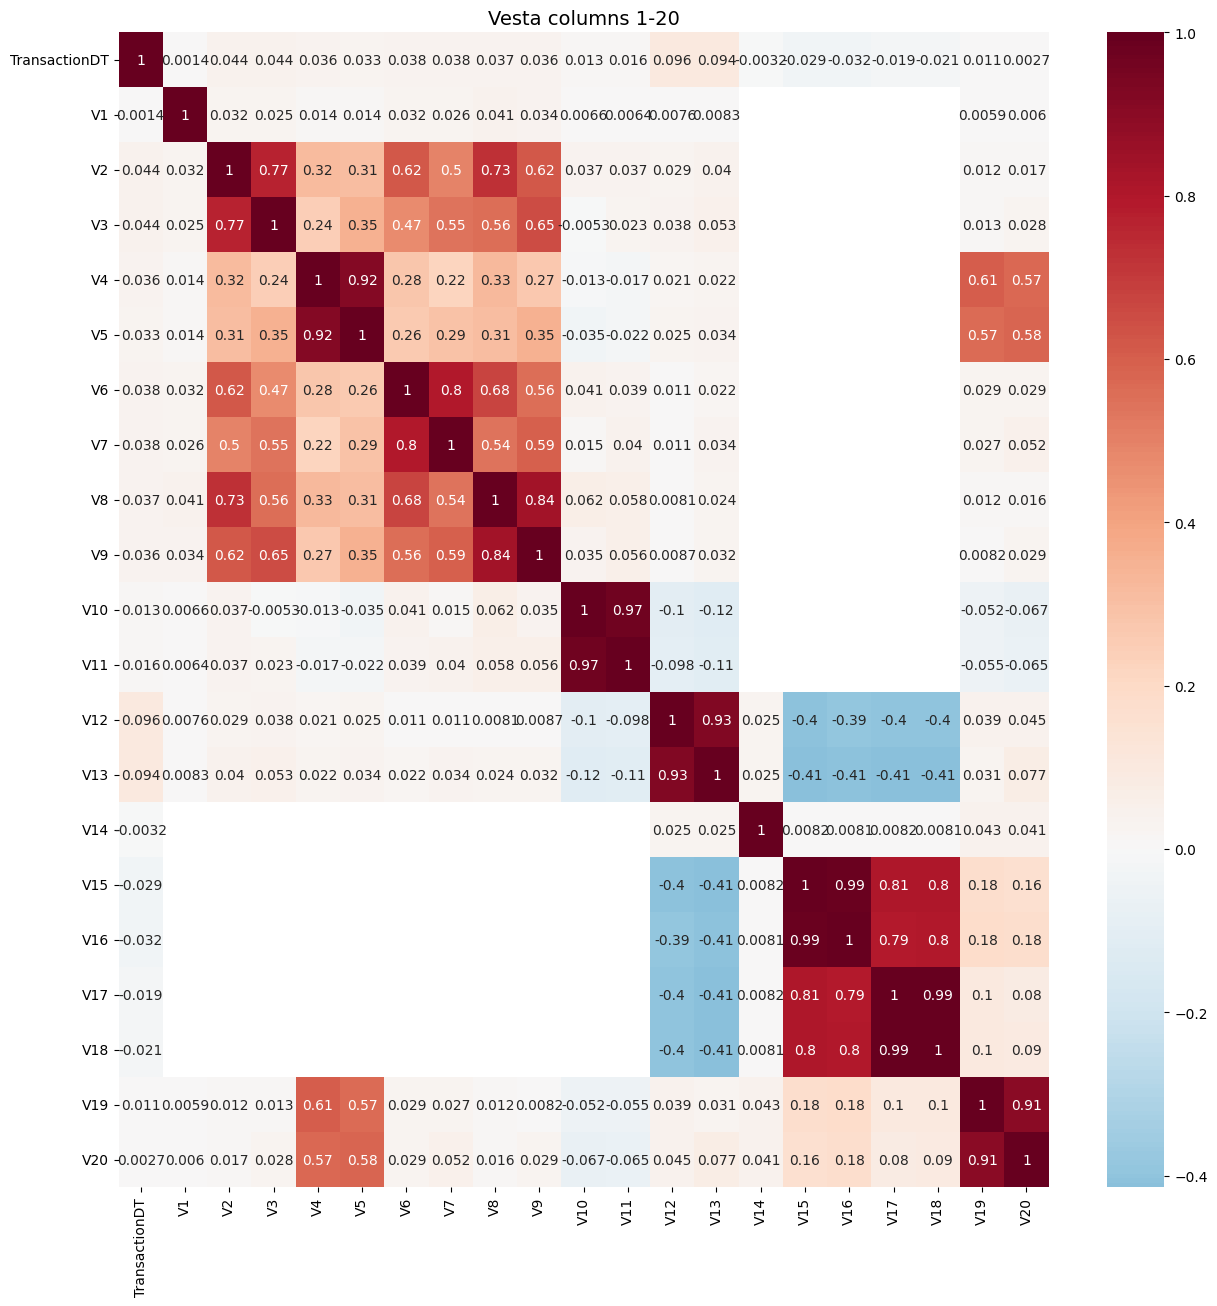

In [19]:
make_corr(X_train, vesta_columns[0], title='Vesta columns 1-20')

In [20]:
def reduce_corr_tuple(df, col1, col2):
    remove_col = None
    
    if df[col1].nunique() > df[col2].nunique():
        remove_col = col1
    else:
        remove_col = col2

    return remove_col

In [ ]:
remove_sets = set()

for i in tqdm(range(len(v_cols))):
    remove_set = set()
    
    corr_pairs = detect_corr_groups(X_train, v_cols[i])
    
    for pair in corr_pairs:
        if pair[0] in remove_set or pair[1] in remove_set:
            continue
        else:
            remove_col = reduce_corr_tuple(X_train, pair[0], pair[1])
            remove_set.add(remove_col)
            
    remove_sets = remove_sets.union(remove_set)

In [ ]:
M_features = [f"M{i}" for i in range(1, 10)]      
C_features = [f"C{i}" for i in range(1, 15)]       
D_features = [f"D{i}" for i in range(1, 16)]       
V_features = [f"V{i}" for i in range(1, 340)]
masked_col = M_features + C_features + D_features + V_features
sparse_features = []

sparsity_threshold = 0.
for col in masked_col:
    missing_ratio = train_data[col].isna().mean()  
    zero_ratio = (train_data[col] == 0).mean()  
    
    total_sparsity = missing_ratio + zero_ratio  
    
    if total_sparsity > sparsity_threshold:
        sparse_features.append(col)

print("Highly sparse features:", sparse_features)

Highly sparse features: ['C3', 'D6', 'D7', 'D12', 'D13', 'D14', 'V27', 'V28', 'V68', 'V89', 'V104', 'V135', 'V138', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146', 'V147', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166', 'V169', 'V172', 'V173', 'V174', 'V175', 'V177', 'V178', 'V179', 'V180', 'V181', 'V182', 'V183', 'V184', 'V185', 'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V211', 'V212', 'V213', 'V214', 'V215', 'V216', 'V220', 'V223', 'V224', 'V225', 'V226', 'V227', 'V231', 'V232', 'V233', 'V234', 'V235', 'V236', 'V237', 'V238', 'V239', 'V266', 'V267', 'V268', 'V269', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276', 'V277', 'V278', 'V281', 'V286', 'V297', 'V300', 'V301', 'V311', 'V319', 'V322', 'V323', 'V324', 'V325', 'V326', 'V327', 'V328', 'V329', 'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338', 'V339']


Numeric and Categorical Feature split

In [6]:
numerical_features = train_data.select_dtypes(include=[np.number])
categorical_features = train_data.select_dtypes(exclude=[np.number])

print(numerical_features.columns)
print(categorical_features.columns)
print(len(numerical_features.columns) + len(categorical_features.columns) == len(train_data.columns))

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'card1',
       'card2', 'card3', 'card5', 'addr1', 'addr2',
       ...
       'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_24', 'id_25',
       'id_26', 'id_32'],
      dtype='object', length=403)
Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1',
       'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15',
       'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33',
       'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType',
       'DeviceInfo'],
      dtype='object')
True


In [7]:
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt

variance_threshold = 0.01
selector = VarianceThreshold(threshold=variance_threshold)
exclude_columns = {"TransactionID", "isFraud", "TransactionDT", "TransactionAmt"}

numerical_features.drop(columns=exclude_columns, errors='ignore')
selector.fit(numerical_features)
low_variance_features = numerical_features.columns[~selector.get_support()].tolist()

print("Low variance features:", low_variance_features)

Low variance features: ['V1', 'V14', 'V27', 'V28', 'V41', 'V65', 'V68', 'V88', 'V89', 'V107', 'V108', 'V110', 'V111', 'V112', 'V113', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V240', 'V241', 'V305']


c:\Users\Henry\Vs Code Projects\Real-Time-Fraud-Detection-Pipeline\Fraud-Detection-Analysis\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:4316: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


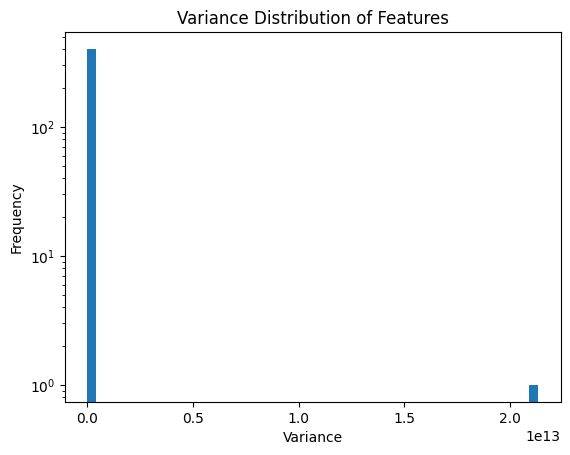

In [8]:
variances = np.var(numerical_features)

plt.hist(variances, bins=50, log=True)
plt.xlabel("Variance")
plt.ylabel("Frequency")
plt.title("Variance Distribution of Features")
plt.show()

Dropping irrelevant models (Test 1)

In [9]:
features_to_drop = list(set(sparse_features + low_variance_features))
print(features_to_drop)
print(type(features_to_drop))

fined_train_data = train_data.drop(columns=features_to_drop)
fined_train_data

['V277', 'V162', 'V177', 'V145', 'V89', 'V329', 'V143', 'V178', 'V173', 'V135', 'V141', 'V325', 'V206', 'V107', 'V183', 'V119', 'V241', 'V146', 'V239', 'V266', 'V324', 'V159', 'V208', 'V210', 'V331', 'V227', 'V328', 'V14', 'V163', 'V240', 'V301', 'V267', 'V166', 'V339', 'V180', 'V27', 'V272', 'V112', 'V185', 'V41', 'V110', 'V205', 'D6', 'V322', 'V160', 'V275', 'D12', 'V108', 'V212', 'V234', 'V305', 'V174', 'V65', 'V68', 'V334', 'V232', 'V335', 'V237', 'V273', 'V281', 'V104', 'V271', 'V327', 'V338', 'V214', 'V88', 'V268', 'V181', 'V216', 'V326', 'V215', 'D14', 'V1', 'V311', 'V300', 'V179', 'V182', 'V226', 'V111', 'V172', 'V175', 'V144', 'V286', 'V161', 'V224', 'V274', 'V269', 'D13', 'V236', 'V330', 'V333', 'V184', 'V223', 'V142', 'C3', 'V235', 'V238', 'V278', 'V336', 'V319', 'V233', 'V297', 'V213', 'V332', 'V118', 'V121', 'V337', 'V231', 'V28', 'V117', 'V209', 'V164', 'V207', 'V122', 'V169', 'D7', 'V270', 'V225', 'V147', 'V323', 'V276', 'V120', 'V220', 'V165', 'V113', 'V211', 'V138']
<c

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.50,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.00,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,3577538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
fined_categorical_features = fined_train_data.select_dtypes(exclude=[np.number])
print(fined_categorical_features.columns)

Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1',
       'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15',
       'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33',
       'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType',
       'DeviceInfo'],
      dtype='object')


In [11]:
fined_categorical_features.fillna("missing", inplace=True)
fined_categorical_features

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,...,id_30,id_31,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,W,discover,credit,missing,missing,T,T,T,M2,F,...,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing
1,W,mastercard,credit,gmail.com,missing,missing,missing,missing,M0,T,...,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing
2,W,visa,debit,outlook.com,missing,T,T,T,M0,F,...,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing
3,W,mastercard,debit,yahoo.com,missing,missing,missing,missing,M0,T,...,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing
4,H,mastercard,credit,gmail.com,missing,missing,missing,missing,missing,missing,...,Android 7.0,samsung browser 6.2,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,W,visa,debit,missing,missing,T,T,T,M0,T,...,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing
590536,W,mastercard,debit,gmail.com,missing,T,F,F,M0,F,...,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing
590537,W,mastercard,debit,gmail.com,missing,T,F,F,missing,missing,...,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing
590538,W,mastercard,debit,aol.com,missing,T,T,T,M0,F,...,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing


Standardize format for categorical features
1. Label Encoding
2. One-hot encoding

Data Cleaning

In [12]:
for i in range(len(fined_categorical_features.columns)):
    print(fined_categorical_features.columns[i], ":", fined_categorical_features.iloc[:, i].unique())

ProductCD : ['W' 'H' 'C' 'S' 'R']
card4 : ['discover' 'mastercard' 'visa' 'american express' 'missing']
card6 : ['credit' 'debit' 'missing' 'debit or credit' 'charge card']
P_emaildomain : ['missing' 'gmail.com' 'outlook.com' 'yahoo.com' 'mail.com'
 'anonymous.com' 'hotmail.com' 'verizon.net' 'aol.com' 'me.com'
 'comcast.net' 'optonline.net' 'cox.net' 'charter.net' 'rocketmail.com'
 'prodigy.net.mx' 'embarqmail.com' 'icloud.com' 'live.com.mx' 'gmail'
 'live.com' 'att.net' 'juno.com' 'ymail.com' 'sbcglobal.net'
 'bellsouth.net' 'msn.com' 'q.com' 'yahoo.com.mx' 'centurylink.net'
 'servicios-ta.com' 'earthlink.net' 'hotmail.es' 'cfl.rr.com'
 'roadrunner.com' 'netzero.net' 'gmx.de' 'suddenlink.net'
 'frontiernet.net' 'windstream.net' 'frontier.com' 'outlook.es' 'mac.com'
 'netzero.com' 'aim.com' 'web.de' 'twc.com' 'cableone.net' 'yahoo.fr'
 'yahoo.de' 'yahoo.es' 'sc.rr.com' 'ptd.net' 'live.fr' 'yahoo.co.uk'
 'hotmail.fr' 'hotmail.de' 'hotmail.co.uk' 'protonmail.com' 'yahoo.co.jp']
R_emaild

In [13]:
fined_categorical_features["P_emaildomain"] = fined_categorical_features["P_emaildomain"].replace("missing", np.nan)
fined_categorical_features["R_emaildomain"] = fined_categorical_features["R_emaildomain"].replace("missing", np.nan)

top_domains_P = fined_categorical_features['P_emaildomain'].dropna().value_counts().head(3)
top_domains_R = fined_categorical_features['R_emaildomain'].dropna().value_counts().head(3)

def categorize_domains(domain, top_domains):
    if pd.isna(domain):
        return 'missing'
    return domain if domain in top_domains else 'others'

fined_categorical_features['P_emaildomain'] = fined_categorical_features['P_emaildomain'].apply(categorize_domains, top_domains=(top_domains_P.index))
fined_categorical_features['R_emaildomain'] = fined_categorical_features['R_emaildomain'].apply(categorize_domains, top_domains=(top_domains_R.index))

print(fined_categorical_features['P_emaildomain'].value_counts())
print(fined_categorical_features['R_emaildomain'].value_counts())

P_emaildomain
gmail.com      228355
others         121545
yahoo.com      100934
missing         94456
hotmail.com     45250
Name: count, dtype: int64
R_emaildomain
missing          453249
gmail.com         57147
others            32106
hotmail.com       27509
anonymous.com     20529
Name: count, dtype: int64


After looking into all categorical columns' unique values, some should be encoding using one-hot encoding, some should use label encoding.

In [14]:
fined_categorical_features

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,...,id_30,id_31,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,W,discover,credit,missing,missing,T,T,T,M2,F,...,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing
1,W,mastercard,credit,gmail.com,missing,missing,missing,missing,M0,T,...,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing
2,W,visa,debit,others,missing,T,T,T,M0,F,...,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing
3,W,mastercard,debit,yahoo.com,missing,missing,missing,missing,M0,T,...,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing
4,H,mastercard,credit,gmail.com,missing,missing,missing,missing,missing,missing,...,Android 7.0,samsung browser 6.2,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,W,visa,debit,missing,missing,T,T,T,M0,T,...,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing
590536,W,mastercard,debit,gmail.com,missing,T,F,F,M0,F,...,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing
590537,W,mastercard,debit,gmail.com,missing,T,F,F,missing,missing,...,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing
590538,W,mastercard,debit,others,missing,T,T,T,M0,F,...,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing


In [15]:
fined_categorical_features.drop(columns="id_33", inplace=True)
fined_train_data.drop(columns="id_33", inplace=True)

In [16]:
def generalize_os(os_name):
    if pd.isna(os_name) or os_name == 'missing':
        return 'unknown'
    os_name = str(os_name).lower()
    if 'windows' in os_name:
        return 'Windows'
    elif 'mac os' in os_name:
        return 'Mac OS X'
    elif 'ios' in os_name:
        return 'iOS'
    elif 'android' in os_name:
        return 'Android'
    elif 'linux' in os_name:
        return 'Linux'
    return 'Other'


def categorize_browser(browser):
    browser = str(browser).lower()
    if 'chrome' in browser:
        return 'Chrome'
    elif 'firefox' in browser or 'waterfox' in browser or 'cyberfox' in browser or 'icedragon' in browser:
        return 'Firefox'
    elif 'safari' in browser:
        return 'Safari'
    elif 'edge' in browser:
        return 'Edge'
    elif 'ie' in browser or 'internet explorer' in browser:
        return 'IE'
    elif 'samsung' in browser:
        return 'Samsung'
    elif 'opera' in browser:
        return 'Opera'
    elif 'android webview' in browser or 'webview' in browser:
        return 'Android Webview'
    else:
        return 'Other'

fined_categorical_features['id_30'] = fined_categorical_features['id_30'].apply(generalize_os)
fined_categorical_features['id_31'] = fined_categorical_features['id_31'].apply(categorize_browser)

In [17]:
for i in range(len(fined_categorical_features.columns)):
    print(fined_categorical_features.columns[i], ":", fined_categorical_features.iloc[:, i].unique())

ProductCD : ['W' 'H' 'C' 'S' 'R']
card4 : ['discover' 'mastercard' 'visa' 'american express' 'missing']
card6 : ['credit' 'debit' 'missing' 'debit or credit' 'charge card']
P_emaildomain : ['missing' 'gmail.com' 'others' 'yahoo.com' 'hotmail.com']
R_emaildomain : ['missing' 'gmail.com' 'hotmail.com' 'others' 'anonymous.com']
M1 : ['T' 'missing' 'F']
M2 : ['T' 'missing' 'F']
M3 : ['T' 'missing' 'F']
M4 : ['M2' 'M0' 'missing' 'M1']
M5 : ['F' 'T' 'missing']
M6 : ['T' 'F' 'missing']
M7 : ['missing' 'F' 'T']
M8 : ['missing' 'F' 'T']
M9 : ['missing' 'F' 'T']
id_12 : ['missing' 'NotFound' 'Found']
id_15 : ['missing' 'New' 'Found' 'Unknown']
id_16 : ['missing' 'NotFound' 'Found']
id_23 : ['missing' 'IP_PROXY:TRANSPARENT' 'IP_PROXY:ANONYMOUS' 'IP_PROXY:HIDDEN']
id_27 : ['missing' 'Found' 'NotFound']
id_28 : ['missing' 'New' 'Found']
id_29 : ['missing' 'NotFound' 'Found']
id_30 : ['unknown' 'Android' 'iOS' 'Mac OS X' 'Windows' 'Linux' 'Other']
id_31 : ['Other' 'Samsung' 'Safari' 'Chrome' 'Edge' 

In [18]:
fined_numerical_features = fined_train_data.select_dtypes(include=[np.number])
fined_numerical_features

print(len(fined_numerical_features.columns) + len(fined_categorical_features.columns) == len(fined_train_data.columns))
fined_train_data

True


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_30,id_31,id_32,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.50,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.00,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,...,Android 7.0,samsung browser 6.2,32.0,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,3577538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
fined_categorical_features["DeviceType"].value_counts()


DeviceType
missing    449730
desktop     85165
mobile      55645
Name: count, dtype: int64

In [20]:
fined_train_data["DeviceType"].value_counts()

DeviceType
desktop    85165
mobile     55645
Name: count, dtype: int64

In [21]:
from sklearn.preprocessing import LabelEncoder
def encode_features(df):
    one_hot_columns = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 
                       'id_23', 'id_30', 'id_31', 'id_34', 'DeviceType']
    
    label_columns = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 
                     'id_12', 'id_15', 'id_16', 'id_27', 'id_28', 'id_29', 
                     'id_35', 'id_36', 'id_37', 'id_38']
    
    freq_encoding_columns = ['DeviceInfo']
    
    # One-hot encoding
    df = pd.get_dummies(df, columns=one_hot_columns)
    
    # Label encoding
    label_encoder = LabelEncoder()
    for col in label_columns:
        df[col] = label_encoder.fit_transform(df[col].astype(str))
    
    # Frequency encoding 
    for col in freq_encoding_columns:
        freq_map = df[col].value_counts(normalize=True).to_dict()
        df[col] = df[col].map(freq_map)
    
    return df

encoded_categorical_features = encode_features(fined_categorical_features)
encoded_categorical_features


,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_12,...,id_31_Safari,id_31_Samsung,id_34_match_status:-1,id_34_match_status:0,id_34_match_status:1,id_34_match_status:2,id_34_missing,DeviceType_desktop,DeviceType_missing,DeviceType_mobile
0,1,1,1,2,0,1,2,2,2,2,...,False,False,False,False,False,False,True,False,True,False
1,2,2,2,0,1,1,2,2,2,2,...,False,False,False,False,False,False,True,False,True,False
2,1,1,1,0,0,0,0,0,0,2,...,False,False,False,False,False,False,True,False,True,False
3,2,2,2,0,1,0,2,2,2,2,...,False,False,False,False,False,False,True,False,True,False
4,2,2,2,3,2,2,2,2,2,1,...,False,True,False,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,1,1,1,0,1,0,0,0,1,2,...,False,False,False,False,False,False,True,False,True,False
590536,1,0,0,0,0,1,0,0,0,2,...,False,False,False,False,False,False,True,False,True,False
590537,1,0,0,3,2,1,2,2,2,2,...,False,False,False,False,False,False,True,False,True,False
590538,1,1,1,0,0,1,2,2,2,2,...,False,False,False,False,False,False,True,False,True,False


In [22]:
cleaned_train_data = pd.concat([fined_numerical_features, encoded_categorical_features], axis=1)
cleaned_train_data

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,id_31_Safari,id_31_Samsung,id_34_match_status:-1,id_34_match_status:0,id_34_match_status:1,id_34_match_status:2,id_34_missing,DeviceType_desktop,DeviceType_missing,DeviceType_mobile
0,2987000,0,86400,68.50,13926,NaN,150.0,142.0,315.0,87.0,...,False,False,False,False,False,False,True,False,True,False
1,2987001,0,86401,29.00,2755,404.0,150.0,102.0,325.0,87.0,...,False,False,False,False,False,False,True,False,True,False
2,2987002,0,86469,59.00,4663,490.0,150.0,166.0,330.0,87.0,...,False,False,False,False,False,False,True,False,True,False
3,2987003,0,86499,50.00,18132,567.0,150.0,117.0,476.0,87.0,...,False,False,False,False,False,False,True,False,True,False
4,2987004,0,86506,50.00,4497,514.0,150.0,102.0,420.0,87.0,...,False,True,False,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.00,6550,NaN,150.0,226.0,272.0,87.0,...,False,False,False,False,False,False,True,False,True,False
590536,3577536,0,15811049,39.50,10444,225.0,150.0,224.0,204.0,87.0,...,False,False,False,False,False,False,True,False,True,False
590537,3577537,0,15811079,30.95,12037,595.0,150.0,224.0,231.0,87.0,...,False,False,False,False,False,False,True,False,True,False
590538,3577538,0,15811088,117.00,7826,481.0,150.0,224.0,387.0,87.0,...,False,False,False,False,False,False,True,False,True,False


Fine-Tune Baseline Model

1. Train-Test Split with Stratified Sampling

In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split

X = cleaned_train_data.drop('isFraud', axis=1)  
y = cleaned_train_data['isFraud'] 

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


2. Train XGBoost Model with Regularization

In [27]:
from xgboost import XGBClassifier

# Initialize XGBoost model
model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    max_depth=6,  # Adjust as needed
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,  # Regularization via subsampling
    colsample_bytree=0.8  # Regularization via subsampling columns
)

model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

3. Feature Importance

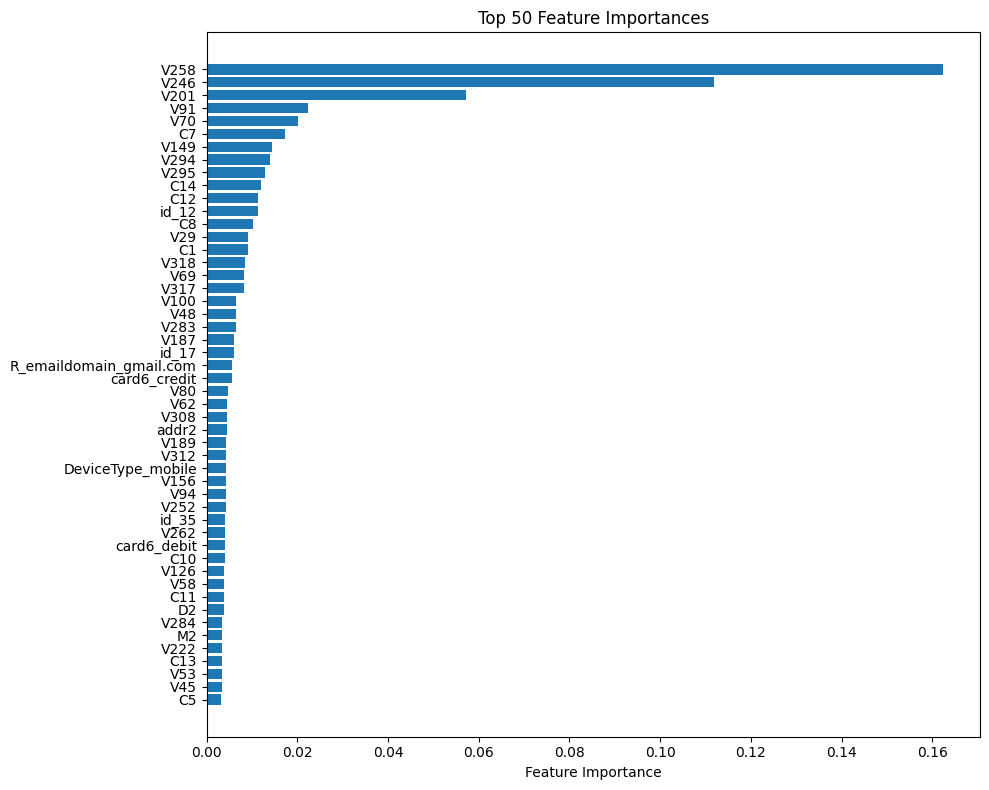

In [34]:
import matplotlib.pyplot as plt
import numpy as np

feature_importance = model.feature_importances_

sorted_idx = np.argsort(feature_importance)[::-1]
top_n = 50
top_features = [X.columns[i] for i in sorted_idx[:top_n]]
top_importance = feature_importance[sorted_idx[:top_n]]

# Plot the top features
plt.figure(figsize=(10, 8))  # Adjust the figure size for better visibility
plt.barh(top_features, top_importance)
plt.xlabel("Feature Importance")
plt.title("Top 50 Feature Importances")
plt.gca().invert_yaxis()

# Rotate y-axis labels for better readability
plt.yticks(rotation=0)  # Rotate labels horizontally for better spacing

plt.tight_layout()  # Adjust layout to avoid overlapping
plt.show()


4. Evaluate the Model on the Validation Set

In [29]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Make predictions on the validation set
y_val_pred = model.predict(X_val)

# Calculate accuracy
print(f'Validation Accuracy: {accuracy_score(y_val, y_val_pred)}')

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
print('Confusion Matrix:')
print(cm)

Validation Accuracy: 0.9778282024361884
Confusion Matrix:
[[85338   143]
 [ 1821  1279]]


In [30]:
# Make predictions on the test set
y_test_pred = model.predict(X_test)

# Calculate accuracy
print(f'Test Accuracy: {accuracy_score(y_test, y_test_pred)}')

# Confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred)
print('Test Set Confusion Matrix:')
print(cm_test)


Test Accuracy: 0.9776024203836037
Test Set Confusion Matrix:
[[85349   133]
 [ 1851  1248]]


1. Categorical Features - Transaction
    - ProductCD
    - card1 - card6
    - addr1, addr2
    - P_emaildomain
    - R_emaildomain
    - M1 - M9
2. Categorical Features - Identity
    - DeviceType
    - DeviceInfo
    - id_12 - id_38

In [23]:
print(train_data.columns)
print("ProductCD:", train_data['ProductCD'].unique(), "Count:", len(train_data['ProductCD'].unique()))
print("card1:", train_data['card1'].unique(), "Count:", len(train_data['card1'].unique()))
print("card2:", train_data['card2'].unique(), "Count:", len(train_data['card2'].unique()))
print("card3:", train_data['card3'].unique(), "Count:", len(train_data['card3'].unique()))
print("card4:", train_data['card4'].unique(), "Count:", len(train_data['card4'].unique()))
print("card5:", train_data['card5'].unique(), "Count:", len(train_data['card5'].unique()))
print("card6:", train_data['card6'].unique(), "Count:", len(train_data['card6'].unique()))
print("addr1:", train_data['addr1'].unique(), "Count:", len(train_data['addr1'].unique()))
print("addr2:", train_data['addr2'].unique(), "Count:", len(train_data['addr2'].unique()))
print("P_emaildomain:", train_data['P_emaildomain'].unique(), "Count:", len(train_data['P_emaildomain'].unique()))
print("R_emaildomain:", train_data['R_emaildomain'].unique(), "Count:", len(train_data['R_emaildomain'].unique()))
print("M1:", train_data['M1'].unique(), "Count:", len(train_data['M1'].unique()))
print("M2:", train_data['M2'].unique(), "Count:", len(train_data['M2'].unique()))
print("M3:", train_data['M3'].unique(), "Count:", len(train_data['M3'].unique()))
print("M4:", train_data['M4'].unique(), "Count:", len(train_data['M4'].unique()))
print("M5:", train_data['M5'].unique(), "Count:", len(train_data['M5'].unique()))
print("M6:", train_data['M6'].unique(), "Count:", len(train_data['M6'].unique()))
print("M7:", train_data['M7'].unique(), "Count:", len(train_data['M7'].unique()))
print("M8:", train_data['M8'].unique(), "Count:", len(train_data['M8'].unique()))
print("M9:", train_data['M9'].unique(), "Count:", len(train_data['M9'].unique()))
print("DeviceType:", train_data['DeviceType'].unique(), "Count:", len(train_data['DeviceType'].unique()))
print("DeviceInfo:", train_data['DeviceInfo'].unique(), "Count:", len(train_data['DeviceInfo'].unique()))
print("id_12:", train_data['id_12'].unique(), "Count:", len(train_data['id_12'].unique()))
print("id_13:", train_data['id_13'].unique(), "Count:", len(train_data['id_13'].unique()))
print("id_14:", train_data['id_14'].unique(), "Count:", len(train_data['id_14'].unique()))
print("id_15:", train_data['id_15'].unique(), "Count:", len(train_data['id_15'].unique()))
print("id_16:", train_data['id_16'].unique(), "Count:", len(train_data['id_16'].unique()))
print("id_17:", train_data['id_17'].unique(), "Count:", len(train_data['id_17'].unique()))
print("id_18:", train_data['id_18'].unique(), "Count:", len(train_data['id_18'].unique()))
print("id_19:", train_data['id_19'].unique(), "Count:", len(train_data['id_19'].unique()))
print("id_20:", train_data['id_20'].unique(), "Count:", len(train_data['id_20'].unique()))
print("id_21:", train_data['id_21'].unique(), "Count:", len(train_data['id_21'].unique()))
print("id_22:", train_data['id_22'].unique(), "Count:", len(train_data['id_22'].unique()))
print("id_23:", train_data['id_23'].unique(), "Count:", len(train_data['id_23'].unique()))
print("id_24:", train_data['id_24'].unique(), "Count:", len(train_data['id_24'].unique()))
print("id_25:", train_data['id_25'].unique(), "Count:", len(train_data['id_25'].unique()))
print("id_26:", train_data['id_26'].unique(), "Count:", len(train_data['id_26'].unique()))
print("id_27:", train_data['id_27'].unique(), "Count:", len(train_data['id_27'].unique()))
print("id_28:", train_data['id_28'].unique(), "Count:", len(train_data['id_28'].unique()))
print("id_29:", train_data['id_29'].unique(), "Count:", len(train_data['id_29'].unique()))
print("id_30:", train_data['id_30'].unique(), "Count:", len(train_data['id_30'].unique()))
print("id_31:", train_data['id_31'].unique(), "Count:", len(train_data['id_31'].unique()))
print("id_32:", train_data['id_32'].unique(), "Count:", len(train_data['id_32'].unique()))
print("id_33:", train_data['id_33'].unique(), "Count:", len(train_data['id_33'].unique()))
print("id_34:", train_data['id_34'].unique(), "Count:", len(train_data['id_34'].unique()))
print("id_35:", train_data['id_35'].unique(), "Count:", len(train_data['id_35'].unique()))
print("id_36:", train_data['id_36'].unique(), "Count:", len(train_data['id_36'].unique()))
print("id_37:", train_data['id_37'].unique(), "Count:", len(train_data['id_37'].unique()))
print("id_38:", train_data['id_38'].unique(), "Count:", len(train_data['id_38'].unique()))



Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=434)
ProductCD: ['W' 'H' 'C' 'S' 'R'] Count: 5
card1: [13926  2755  4663 ... 13166  8767 18038] Count: 13553
card2: [ nan 404. 490. 567. 514. 555. 360. 100. 111. 352. 375. 418. 303. 314.
 543. 583. 148. 321. 269. 361. 272. 399. 569. 453. 417. 512. 545. 266.
 114. 481. 452. 547. 383. 170. 343. 556. 285. 562. 302. 264. 558. 500.
 396. 103. 206. 143. 243. 476. 199. 174. 423. 446. 492. 523. 440. 528.
 161. 535. 354. 117. 455. 325. 158. 268. 122. 479. 147. 215. 480. 265.
 388. 408. 309. 415. 414. 437. 104. 225. 101. 134. 586. 191. 491. 369.
 322. 494. 532. 313. 474. 324. 475. 298. 429. 432. 553. 566. 599. 296.
 251. 310. 242. 204. 250. 270. 346. 316. 194. 587. 390. 135. 536. 254.
 226. 327. 420. 260. 413. 

Columns with too much unique values are hard to intepret.

In [24]:
train_data = train_data.drop(columns=['dist1', 'dist2', 'id_13', 'id_14', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_24', 'id_25', 'id_26', 'id_27', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'M4'])
print(train_data.columns)
train_data

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'id_10', 'id_11', 'id_12', 'id_15', 'id_16', 'id_23', 'id_28', 'id_29',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=410)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_10,id_11,id_12,id_15,id_16,id_23,id_28,id_29,DeviceType,DeviceInfo
0,2987000,0,86400,68.50,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.00,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,...,NaN,100.0,NotFound,New,NotFound,NaN,New,NotFound,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,3577538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Fine-tune Fraud Detection Model (Micro-Fraud Payments, Geolocation Fraud)
1. Microfraud payment

In [25]:
fdd1_train = train_data
fdd1_train.drop(columns=['addr1', 'addr2'])
fdd1_train

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_10,id_11,id_12,id_15,id_16,id_23,id_28,id_29,DeviceType,DeviceInfo
0,2987000,0,86400,68.50,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.00,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,...,NaN,100.0,NotFound,New,NotFound,NaN,New,NotFound,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,3577538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
